In [1]:
import pandas as pd 
import numpy as np 
from datetime import date, datetime
from yahoo_fin import options as op  
import yfinance as yf
import math as ma
from scipy.optimize import minimize,least_squares
import matplotlib.pyplot as plt
import csv

In [13]:
#files= pd.read_csv("taux_tresor.csv", delimiter=",")
data = pd.read_excel("taux_tresor_ex.xlsx")

data["days"]=(data["Date echeance"]-data["Date valeur"])
#convert days into int
data["days"]=data["days"].dt.total_seconds() /(3600*24)
data["days"]=data["days"].astype(int)
data

,Date echeance,Transaction,taux,Date valeur,days
0,2023-10-16,-,0.0297,2023-08-23,54
1,2024-01-15,-,0.0302,2023-08-23,145
2,2024-03-18,-,0.0308,2023-08-23,208
3,2024-11-19,-,0.0338,2023-08-28,449
4,2027-05-17,-,0.0368,2023-08-23,1363
5,2030-06-17,-,0.0390,2023-08-23,2490
6,2032-06-14,-,0.0407,2023-08-23,3218
7,2036-07-14,-,0.0440,2023-08-23,4709
8,2040-04-16,-,0.0473,2023-08-23,6081
9,2051-02-20,-,0.0530,2023-08-23,10043


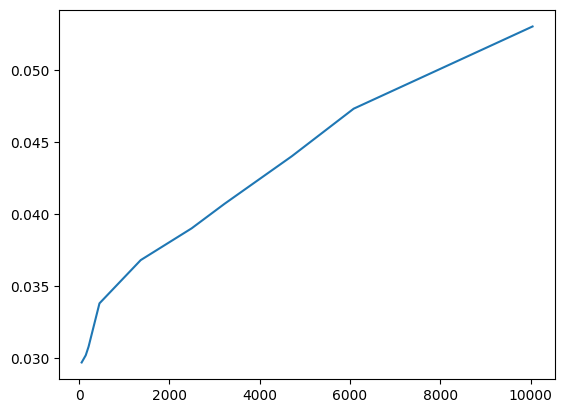

In [3]:
plt.plot(data["days"], data["taux "])


In [4]:
def interpolation_lineaire(x, a, b):
    # methode de lagrange
    return (b[1]*(x-a[0]) -b[0]*(x-a[1]))/ (a[1]- a[0])

def interpolation_lineaire(a, b):
    # methode de lagrange
    r=np.ones((2*len(a)-1,2))
    for i in range((len(a)-1)):
        r[2*i][0]=a[i]
        r[2*i+1][0]= (a[i]+a[i+1])/2
        r[2*i][1]=b[i]
        r[2*i+1][1]= (b[i+1]*((-a[i]+a[i+1])/2) -b[i]*((a[i]-a[i+1])/2))/ (a[i+1]- a[i])
    r[2*len(a)-2][0]=a[len(a)-1]
    r[2*len(a)-2][1]=b[len(a)-1]  
    return r



(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),)

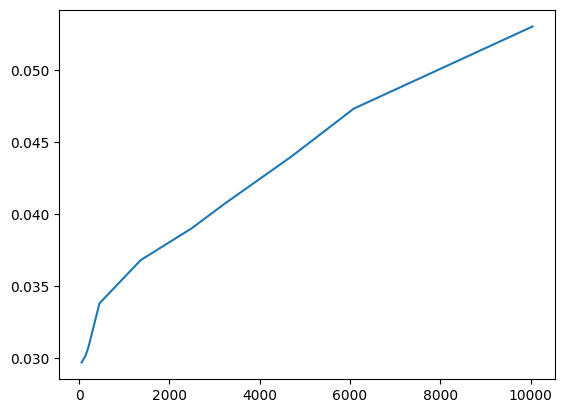

In [12]:
rt= interpolation_lineaire(data["days"], data["taux "]).T
plt.plot(rt[0],rt[1])
rt
np.where((data["days"]-100)>0)


In [6]:
def interpolation_splinecubique_1(A, B):
    """ a t^3 +b t^2 + ct +d = r
        a t^3 +b t^2 + ct +d = r
        a t^3 +b t^2 + ct +d = r
        a t^3 +b t^2 + ct +d = r """
    a=b=c=d=0
    # method de gauss seidel
    for i in range(500):
        a =( B[3]-b*A[3]**2-c*A[3]-d)/ ma.pow(A[3],3)
        b=( B[2]-a*ma.pow(A[2],3)-c*A[2]-d)/ A[2]**2
        c=( B[1]-b*A[1]**2-a*ma.pow(A[1],3)-d)/ A[1]
        d=( B[0]-ma.pow(A[0],3)*a -b*A[0]**2-c*A[0])

    return (a,b,c,d)


In [7]:

def interpolation_splinecubique(A, B):
    """ a t^3 +b t^2 + ct +d = r
        a t^3 +b t^2 + ct +d = r
        a t^3 +b t^2 + ct +d = r
        a t^3 +b t^2 + ct +d = r """
    step=50
    #A is a Pandas
    rt=np.zeros((len(np.arange(A[0],A.iloc[-1]+step,step)),2))
    # method de gauss seidel
    n=0
    for u in np.arange(0,len(A)-3,3):
        a=b=c=d=0
        for i in range(100):
            a =( B[u+3]-b*A[u+3]**2-c*A[u+3]-d)/ ma.pow(A[u+3],3)
            b=( B[u+2]-a*ma.pow(A[u+2],3)-c*A[u+2]-d)/ A[u+2]**2
            c=( B[u+1]-b*A[u+1]**2-a*ma.pow(A[u+1],3)-d)/ A[u+1]
            d=( B[u]-ma.pow(A[u],3)*a -b*A[u]**2-c*A[u])
       
        for j in np.arange(A[u],A[u+3],step):
            #np.append(np.zeros(len(np.arange(A[u],A[u+3],step))),rt)
            rt[n][0]=j
            rt[n][1]=a*ma.pow(j,3) +b*ma.pow(j,2) + c*j +d 
            n=n+1
    
    return rt 

interpolation_splinecubique(data["days"], data["taux "])    

array([[5.40000000e+01, 2.97000000e-02],
       [1.04000000e+02, 2.99123200e-02],
       [1.54000000e+02, 3.02750547e-02],
       [2.04000000e+02, 3.07569488e-02],
       [2.54000000e+02, 3.13267470e-02],
       [3.04000000e+02, 3.19531937e-02],
       [3.54000000e+02, 3.26050338e-02],
       [4.04000000e+02, 3.32510117e-02],
       [4.49000000e+02, 3.38000000e-02],
       [4.99000000e+02, 3.40189645e-02],
       [5.49000000e+02, 3.42303179e-02],
       [5.99000000e+02, 3.44342930e-02],
       [6.49000000e+02, 3.46311224e-02],
       [6.99000000e+02, 3.48210388e-02],
       [7.49000000e+02, 3.50042751e-02],
       [7.99000000e+02, 3.51810637e-02],
       [8.49000000e+02, 3.53516376e-02],
       [8.99000000e+02, 3.55162294e-02],
       [9.49000000e+02, 3.56750717e-02],
       [9.99000000e+02, 3.58283974e-02],
       [1.04900000e+03, 3.59764391e-02],
       [1.09900000e+03, 3.61194295e-02],
       [1.14900000e+03, 3.62576014e-02],
       [1.19900000e+03, 3.63911874e-02],
       [1.249000

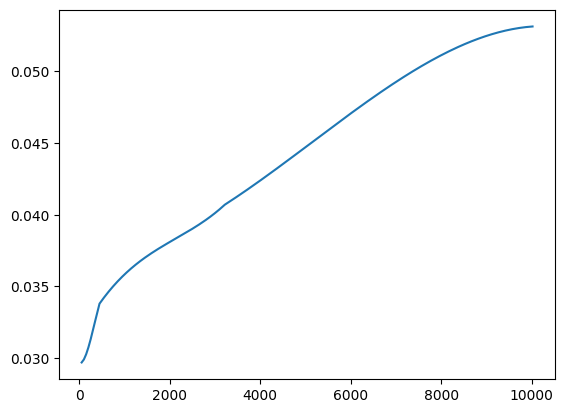

In [8]:
rt = interpolation_splinecubique(data["days"], data["taux "]).T
plt.plot(rt[0],rt[1])

In [2]:
data = pd.read_excel("taux_tresor_ex.xlsx")

data["days"]=(data["Date echeance"]-data["Date valeur"])
#convert days into int
data["days"]=data["days"].dt.total_seconds() /(3600*24)
data["days"]=data["days"].astype(int)/365
data

,Date echeance,Transaction,taux,Date valeur,days
0,2023-10-16,-,0.0297,2023-08-23,0.147945
1,2024-01-15,-,0.0302,2023-08-23,0.397260
2,2024-03-18,-,0.0308,2023-08-23,0.569863
3,2024-11-19,-,0.0338,2023-08-28,1.230137
4,2027-05-17,-,0.0368,2023-08-23,3.734247
5,2030-06-17,-,0.0390,2023-08-23,6.821918
6,2032-06-14,-,0.0407,2023-08-23,8.816438
7,2036-07-14,-,0.0440,2023-08-23,12.901370
8,2040-04-16,-,0.0473,2023-08-23,16.660274
9,2051-02-20,-,0.0530,2023-08-23,27.515068


Model de Nels-siegel-svensson 

In [18]:
#Paramètre du modèle
beta0 = data["taux "].max()
beta1 =data["taux "].max()-data["taux "].min()
beta2=2*data["taux "].mean()-data["taux "].max()-data["taux "].min()
beta3=beta2
#Paramètres d'échelle
alpha1=5
alpha2=5

parms=[beta0,beta1,beta2,beta3,alpha1,alpha2]

In [19]:
#Nelson Siegel Svensson model
def  NSS_model(t,parms):
    return parms[0]+parms[1]*((1-np.exp(-t/parms[4]))/(t/parms[4]))+parms[2]*(((1-np.exp(-t/parms[4]))/(t/parms[4]))-np.exp(-t/parms[4]))+parms[3]*(((1-np.exp(-t/parms[5]))/(t/parms[5]))-np.exp(-t/parms[5]))


In [20]:
def list_taux_(ti, tf,parms):
    taux_=[]
    for i in range(ti,tf+1):
        taux_.append(NSS_model(i,parms))
    return taux_  

def list_taux(days,parms):
    taux_=[]
    for i in days:
        taux_.append(NSS_model(i,parms))
    return taux_    
        

list_taux(data['days'], parms)

[0.054113170365469684,
 0.053414482758623455,
 0.0532889423076923,
 0.05313385300668152,
 0.053044093910491565,
 0.05302413654618474,
 0.053018676196395276,
 0.053012762794648546,
 0.053009883242887676,
 0.0530059842676491]

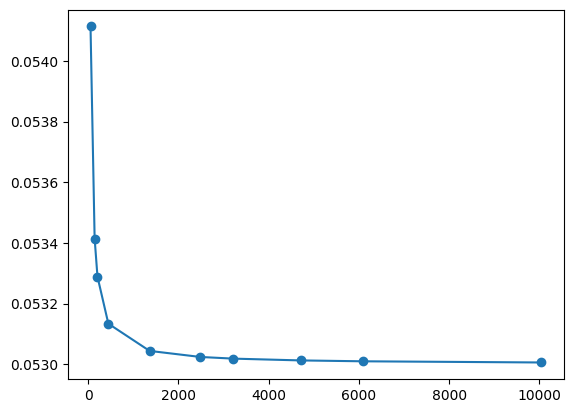

In [21]:
plt.scatter(data["days"], list_taux(data['days'], parms))
plt.plot(data["days"], list_taux(data['days'], parms))

Optimisation of the error

In [22]:
#standard squared error
def SSE_(predict_rate, real_rate):
    err=(predict_rate-real_rate)**2
    return np.sum(err)

def SSE(parms):
    err=(list_taux(data['days'], parms)-data["taux "])**2
    return np.sum(err)

#SSE(list_taux(data['days'], parms), data["taux "])
SSE(parms)

0.0027405949669685624

In [30]:
constraint = ({'type': 'ineq', 'fun': lambda parms: parms[5] },  # Contrainte parms[5] > 0
               {'type': 'ineq', 'fun': lambda parms:parms[4]-1})
op= minimize(SSE,parms, constraints=constraint, tol=0.00001)
op.x,op.fun

(array([ 0.04155372, -0.03936477, -0.06829637, -0.06829664,  4.9999045 ,
         5.00013348]),
 0.0003204771460116402)

[0.02526447052597408,
 0.03548621525116581,
 0.03732396810599701,
 0.03959427862013227,
 0.04090823785839813,
 0.04120038834024895,
 0.04128032093042169,
 0.04136688562619639,
 0.04140903860900098,
 0.04146611465757941]

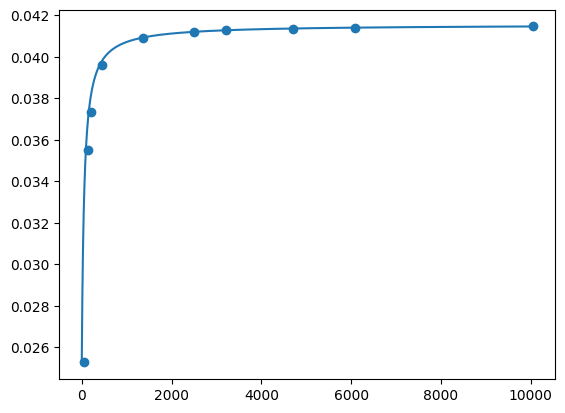

In [32]:
list_taux(data['days'], op.x)
plt.scatter(data["days"], list_taux(data['days'], op.x))
plt.plot(list_taux_(data['days'].iloc[0],data['days'].iloc[-1], op.x))
list_taux_(data['days'].iloc[0],data['days'].iloc[-1], op.x)
list_taux(data['days'], op.x)
#plt.plot(data["days"], data["taux "])

Spline cubique

In [29]:
def  splineCubique(t, parms, a,b):
    return 1 + parms[0]*t +parms[1]*t**2+ parms[2]*t**3 +(parms[3]-parms[2])*max((t-a),0)**3 +(parms[4]-parms[3])*max((t-b),0)**3


def taux_predict(exp, parms ):
    rate=[]
    time=[]
    n= int(len(exp)/3)
    for j in range(n):
      tmp= exp[j*3:(j+1)*3]
      temp= parms[j*5:(j+1)*5]
      print(tmp)
      for i in range(3):
        rate.append(0)#splineCubique(tmp[i],temp, tmp[1],tmp[2])
        time.append(tmp[i])
        
    return[rate,time] 

def SSE_cubique(parms):
    err=(taux_predict( data["days"]/365 ,parms)[0]-data["taux "])**2
    return np.sum(err)

parms= np.ones(5*4)*-0.01
spline=taux_predict(data["days"]/365 ,parms)
plt.scatter(spline[1],spline[0])
plt.plot(spline[1],spline[0])

#op= least_squares(SSE_cubique,parms)
#SSE_cubique(parms)
spline[0]

0    0.147945
1    0.397260
2    0.569863
Name: days, dtype: float64
3    1.230137
4    3.734247
5    6.821918
Name: days, dtype: float64


KeyError: 0

In [14]:
def  splineCubique(t, parms, a,b):
    return 1 + parms[0]*t +parms[1]*t**2+ parms[2]*t**3 +(parms[3]-parms[2])*max((t-a),0)**3 +(parms[4]-parms[3])*max((t-b),0)**3

def taux_predict_(taux, exp, parms ):
    rate=[]
    time=[]
    for i in range(0,len(taux)-3,3):
        t=np.arange(exp[i], exp[i+3], abs((exp[i+3]-exp[i])/10))
        for j in range(len(t)):
            rate.append(splineCubique(j,parms,taux[i+1],taux[i+2]))
            time.append(j)

    return[rate,time]  

def taux_predict(exp, parms ):
    rate=[]
    time=[]
    for i in range(0,len(exp)-3,3):
        n=int(i/3)
        for j in range(3):
            rate.append(splineCubique(exp[i+j],parms[n:(n+1)*5], exp[i+1],exp[i+2]))
            time.append(exp[i+j])
    rate.append(splineCubique(exp[len(exp)-1],parms,exp[len(exp)-2],exp[len(exp)-3]))
    time.append(exp[len(exp)-1])
    return[rate,time]


def SSE_cubique(parms):
    err=(taux_predict( data["days"]/365 ,parms)[0]-data["taux "])**2
    return np.sum(err)

In [17]:
np.arange(0,len(data["days"])-3,3)

array([0, 3, 6])

[0.9982692881802081,
 0.9938223008248998,
 0.9892033362038163,
 0.9539513719965966,
 0.3024859053460388,
 -2.708427292380538,
 -6.718441207864951,
 -22.267196635416962,
 -48.18529430456765,
 -215.15674442340568]

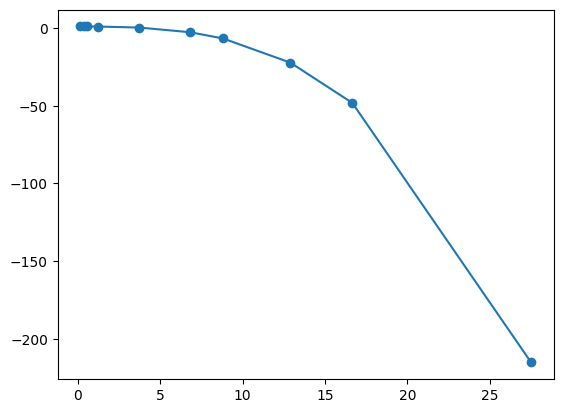

In [15]:
parms= np.ones(5*3)*-0.01
spline=taux_predict(data["days"]/365 ,parms)
plt.scatter(spline[1],spline[0])
plt.plot(spline[1],spline[0])

op= least_squares(SSE_cubique,parms)
SSE_cubique(parms)
spline[0]

[-0.00999321 -0.00959486  0.00053316 -0.0109124  -0.00767228 -0.00586763
 -0.00954803 -0.00952212  0.0004758  -0.0098233  -0.01       -0.01
 -0.01       -0.01       -0.01      ]


[0.14794520547945206,
 0.3972602739726027,
 0.5698630136986301,
 1.2301369863013698,
 3.734246575342466,
 6.821917808219178,
 8.816438356164383,
 12.901369863013699,
 16.660273972602738,
 27.515068493150686]

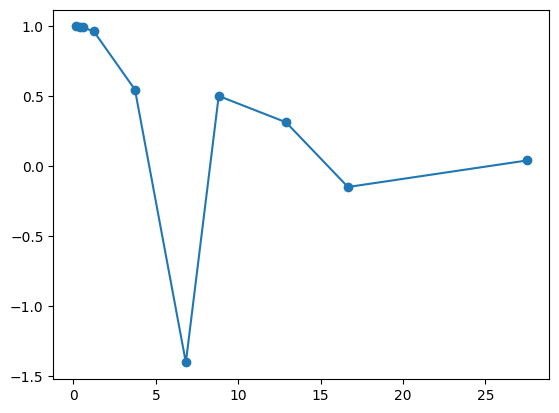

In [10]:
op.x,op.fun
parms=op.x
spline=taux_predict(data["days"]/365, op.x)
plt.scatter(spline[1],spline[0])
plt.plot(spline[1],spline[0])
spline[1]


[-0.011620176469348986,
 -0.015383371235736965,
 -0.018668073868662427,
 -0.03593584086339763,
 -0.13212356456434426,
 -0.2031701669720748,
 -0.21777587451575453,
 -0.21900988167505275,
 -0.20945561217162212,
 -0.17761920444827528]

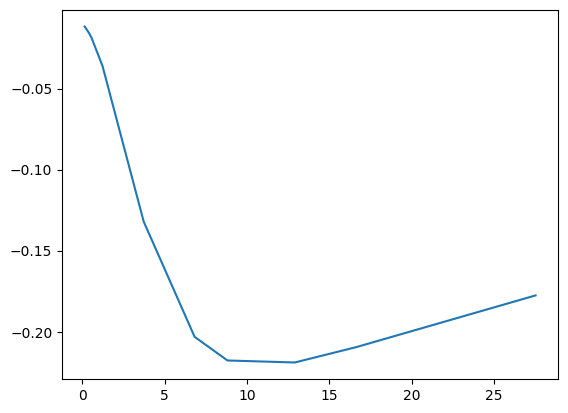

In [17]:
def  splineCubique0(t, parms, expiration):
    sc= 1 + parms[0]*t +parms[1]*t**2+ parms[2]*t**3 
    for i in  range(1,len(expiration)-1):
        sc=sc+(parms[i+2]-parms[i+1])*max((t-expiration[i]),0)**3 
    return sc
def taux_predict0( expiration, parms ):
    rate=[]
    time=[]
    for i in expiration:
        r=1-(1/splineCubique0(i,parms,expiration))**(1/i)
        rate.append(-r)
        time.append(i)
    return[rate,time]  

def SSE_cubique0(parms):
    err=(taux_predict0(data["days"] ,parms)[0]-data["taux "])**2
    return np.sum(err)

parms= 0.01*np.ones(len(data["days"])+3)
spline=taux_predict0(data["days"]/365 ,parms)
#plt.scatter(spline[1],spline[0])
plt.plot(spline[1],spline[0])
spline[0]

In [15]:
SSE_cubique0(parms)
op=least_squares(SSE_cubique0,parms)
op.fun, op.x

C:\Users\hp\AppData\Local\Temp\ipykernel_5792\2505847958.py:10: RuntimeWarning: invalid value encountered in double_scalars
  r=1-(1/splineCubique0(i,parms,expiration))**(1/i)


(array([0.]),
 array([ 0.00999118,  0.00948052, -0.02604761,  0.00964766,  0.00958068,
         0.01      ,  0.01      ,  0.01      ,  0.01      ,  0.01      ,
         0.01      ,  0.01      ,  0.01      ]))

[ 0.00999118  0.00948052 -0.02604761  0.00964766  0.00958068  0.01
  0.01        0.01        0.01        0.01        0.01        0.01
  0.01      ] [0.]


[-0.010756727480404016,
 -0.009582054922494976,
 -0.007215949794423082,
 0.0010146637003212167,
 -0.03389421865976716,
 -0.13498692570821236,
 -0.1712580879054102,
 -0.19505273238963894,
 -0.1943391833393221,
 -0.17137766214338568]

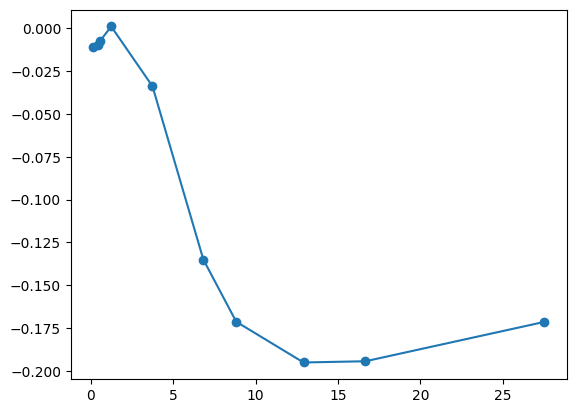

In [16]:
print(op.x,op.fun)
spline=taux_predict0(data["days"]/365 ,op.x)
plt.scatter(spline[1],spline[0])
plt.plot(spline[1],spline[0])
spline[0]

Vacisek

In [ ]:
class SplineCubique(Donnee):
    def __init__(self, taux, maturite):
        super().__init__(taux, maturite)

    def regressionSpline(self, parms):
        t=self._maturite
        r=t
        r1= t**2
        r2= t**3- max(t-t[1])**3  
        r3=max(t-t[2])**3
        taux=1+parms[0]*r+parms[1]*r1+parms[2]*r2+parms[3]*r3
        error= np.sum((taux - self._taux)**2)  
        return error
    def parmsValue(self):
        op= minimize(self.regressionSpline,[0.1,0.1,0.1,0.1], tol=0.00001)
        return op.x, op.fun, op.success
        #Y=pd.concat([r,r1,r2,r3], axis=1, keys=["r","r1","r2","r3"])


In [ ]:
def vasicekModel():
    N=100
    w=np.random.normal(N)

    

In [72]:
import pandas as pd 
import numpy as np 
import math as ma
from scipy.optimize import minimize,least_squares,curve_fit
import matplotlib.pyplot as plt
from datetime import date, datetime
from charger_donnee import Donnee

class SplineCubique(Donnee):
    def __init__(self, taux, maturite):
        super().__init__(taux, maturite/360)
        self.pseudomaturite=self._maturite[0:4]
        self.pseudotaux= self._maturite[0:4]

    def  splineCubique0(self, parms):
        t=self._maturite
        sc= 1 + parms[0]*t +parms[1]*t**2+ parms[2]*t**3 
        for i in  range(1,len(self._maturite)-1):
            c=self._maturite[i]
            sc=sc+(parms[i+2]-parms[i+1])*np.maximum((t-c),0)**3 
        error= np.sum((sc - self._taux)**2)  
        return error

    def regressionSpline(self, parms,t,taux_):
        r2= t**3- np.maximum((t-t[1]),0)**3  
        r3=np.maximum((t-t[1]),0)**3
        taux=1+parms[0]*t+parms[1]*t**2+parms[2]*r2+parms[3]*r3
        error= np.sum((taux - taux_)**2)  
        return error
    
    def parmsValue(self ,n,tau):
        op= minimize(self.regressionSpline,np.ones(4)*-0.01, tol=0.00001, args=(n,tau))
        #op= minimize(self.splineCubique0,np.ones(len(self._maturite)+2)*-0.01, tol=0.00001)
        return op.x, op.fun, op.success, op.message
 
    def plageDeTaux(self,a):
        maturite=self._maturite.to_numpy()
        for i in range(0, len(self._taux),3):
              if i + 4 <= len(self._maturite):
               if  (maturite[i]<=a and maturite[i+3]>=a ):
                 return self._taux[i:i+4]

    def plageDeMaturite(self,a):
        maturite=self._maturite.to_numpy()
        for i in range(0, len(self._maturite),3):
            if i + 4 <= len(self._maturite):
              if  (maturite[i]<=a and maturite[i+3]>=a ):
                return  self._maturite[i:i+4]

    def  splineCubique(self,t):
        m=self.plageDeMaturite(t).to_numpy()
        tau=self.plageDeTaux(t).to_numpy()
        op= minimize(self.regressionSpline,np.ones(4)*-0.01, tol=0.00001, args=(m,tau))
        parms=op.x
        r2= t**3- np.maximum((t-self.pseudomaturite[1]),0)**3  
        r3=np.maximum((t-self.pseudomaturite[1]),0)**3
        taux=1+parms[0]*t+parms[1]*t**2+parms[2]*r2+parms[3]*r3
        return  taux, op.success
     
    def plotsplineCubique(self):
      plt.plot(self._maturite,self.splineCubique())  
      plt.xlabel("Maturité")
      plt.ylabel("Taux Zéro coupon")
      plt.legend("Interpolation spline cubique")
      plt.show()

data = pd.read_excel("taux_tresor_ex.xlsx")
data["days"]=(data["Date echeance"]-data["Date valeur"])
#convert days into int
data["days"]=data["days"].dt.total_seconds() /(3600*24)
data["days"]=data["days"].astype(int)

ntsp=SplineCubique(data["taux "],data["days"])

#print(ntsp.splineCubique0(np.ones(12)*0.1))
#print(ntsp.parmsValue(ntsp.plageDeMaturite(2), ntsp.plageDeTaux(2)))
print(ntsp.plageDeTaux(9))
print(ntsp.splineCubique(9.8))


6    0.0407
7    0.0440
8    0.0473
9    0.0530
Name: taux , dtype: float64
(0.7925263616512317, True)
